In [7]:

%cd /content/drive/MyDrive/Github/Machine_Learning_personal_learning

/content/drive/MyDrive/Github/Machine_Learning_personal_learning


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import xgboost as xgb
import matplotlib.pyplot as plt

In [8]:
# Importing the dataset
data_tr = pd.read_csv("../../ML_datasets/Crystal_Structure_Classification/train_dataset.csv")
data_tr.head()

,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
0,0,0,0.52,0.52,0.93,2.18,2.54,2.214685,2.313698,-1.728214,0.582680,0.000000,0.664286,cubic
1,0,0,1.03,0.86,0.60,1.27,1.90,2.500930,0.000000,-1.768643,0.859135,0.000000,0.428571,cubic
2,2,4,0.92,0.67,0.53,1.83,1.88,2.290644,1.930311,-1.468464,0.849994,4.936558,0.378571,cubic
3,1,5,1.64,1.38,0.62,0.82,2.36,3.025719,1.745600,-1.974429,1.064161,3.977376,0.442857,orthorhombic
4,0,0,0.57,0.57,0.71,2.20,1.30,2.300109,2.027412,-1.622357,0.660190,0.000000,0.507143,cubic


array([[<Axes: title={'center': 'v(A)'}>,
        <Axes: title={'center': 'v(B)'}>,
        <Axes: title={'center': 'r(AXII)(Å)'}>,
        <Axes: title={'center': 'r(AVI)(Å)'}>],
       [<Axes: title={'center': 'r(BVI)(Å)'}>,
        <Axes: title={'center': 'EN(A)'}>,
        <Axes: title={'center': 'EN(B)'}>,
        <Axes: title={'center': 'l(A-O)(Å)'}>],
       [<Axes: title={'center': 'l(B-O)(Å)'}>,
        <Axes: title={'center': 'ΔENR'}>, <Axes: title={'center': 'tG'}>,
        <Axes: title={'center': 'τ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

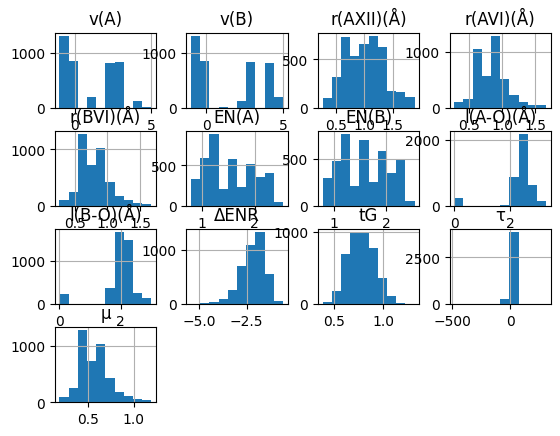

In [9]:
data_tr.hist()

In [10]:
# Assigning X and Y: X - all features except last column of dataset, Y - One hot encoding of classification column (final column of dataset)
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(data_tr[["Lowest distortion"]])
Y = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out(['Lowest distortion']))
X = data_tr.drop(columns = ["Lowest distortion"])
Y.head()

,Lowest distortion_cubic,Lowest distortion_orthorhombic,Lowest distortion_rhombohedral,Lowest distortion_tetragonal
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [11]:
# convert y to one d array where each row is a 1-D array of hot encoded features
#Y['Lowest distortion'] = Y.apply(lambda row: [row['Lowest distortion_cubic'], row['Lowest distortion_orthorhombic'], row['Lowest distortion_rhombohedral'], row['Lowest distortion_tetragonal']], axis=1)
#Y = Y['Lowest distortion']
y_labels = np.argmax(Y, axis=1)
y_labels[0:30]
Y = y_labels

In [12]:
# Find correlations between features in X in abs scale
corr_matrix = X.corr().abs()
# print(corr_matrix["r(BVI)(Å)"], corr_matrix["μ"], corr_matrix["r(AVI)(Å)"], corr_matrix["r(AXII)(Å)"])
# corr_matrix = corr_matrix.mask(np.eye(corr_matrix.shape[0], dtype=bool))
corr_series = corr_matrix.unstack()
corr_series = corr_series.sort_values(ascending = False)
corr_series = corr_series.drop_duplicates()
# print(corr_series[0:10])

# plotting correlation matrix
fig = px.imshow(corr_matrix, text_auto = True)
fig.show()

# plotting between 2 correlations
fig = px.scatter(x = corr_matrix["r(AVI)(Å)"], y = corr_matrix["r(AXII)(Å)"], labels = {"x": "r(AVI)(Å)", "y": "r(AXII)(Å)"})
fig.show()

In [13]:
# Preprocessing X using strandard scalar (X - \mu/ \sigma)
scalar = StandardScaler()
X = pd.DataFrame(scalar.fit_transform(X), columns = X.columns)

# can drop either "μ" or "r(BVI)(Å)" as their correlation value = 1 (selected "μ")
# can also deop either of "r(AVI)(Å)" or "r(AXII)(Å)" as their correlation value ~ 0.93 (future work)
X = X.drop(columns = ["μ"])

In [245]:
# We will use stratified k-fold cross validation to train the models
# setting accuracy score as scoring metric for k-fold
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing models to be used
models = {
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=18),
    "GradientBoosting": GradientBoostingClassifier(random_state=18),
    "Bagging": BaggingClassifier(),
    "ExtraTrees": ExtraTreesClassifier(random_state=18),
    "KNeighbors": KNeighborsClassifier()
    }

In [246]:
# k = 5 splits
scores_k5 = []
times_k5 = []

# Producing cross validation score and runtime for the models and tabulationg them in a table
for i in models:
  model = models[i]
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # k = 5 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k5.append(np.mean(scores))
  times_k5.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")


SVC
Scores: [0.59063625 0.58943577 0.59063625 0.59063625 0.59063625]
Mean Score: 0.5903961584633853
Model training time: 9.507622718811035 seconds
GaussianNB
Scores: [0.53781513 0.54981993 0.53541417 0.57743097 0.55822329]
Mean Score: 0.5517406962785114
Model training time: 0.10265421867370605 seconds
RandomForest
Scores: [0.79111645 0.81272509 0.77070828 0.79831933 0.81872749]
Mean Score: 0.7983193277310925
Model training time: 3.278607130050659 seconds
GradientBoosting
Scores: [0.75870348 0.78391357 0.73469388 0.75630252 0.77070828]
Mean Score: 0.7608643457382953
Model training time: 16.998990058898926 seconds
Bagging
Scores: [0.78391357 0.78511405 0.75630252 0.77190876 0.79591837]
Mean Score: 0.7786314525810324
Model training time: 0.9698905944824219 seconds
ExtraTrees
Scores: [0.78271309 0.79351741 0.75030012 0.78391357 0.80072029]
Mean Score: 0.7822328931572629
Model training time: 2.071688413619995 seconds
KNeighbors
Scores: [0.73109244 0.7334934  0.71548619 0.73589436 0.74069628

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}
XGBoostClassifier
0      0.724370
1      0.737815
2      0.745258
3      0.748860
4      0.750780
         ...   
195    0.797839
196    0.798559
197    0.798559
198    0.798079
199    0.798079
Name: test-merror-mean, Length: 200, dtype: float64
Mean Sc

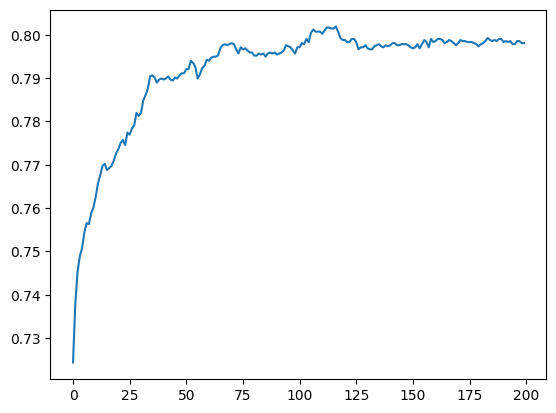

In [247]:
# for XGBoost, remember scores here outputed from xgb.cv is from every boosted rounds
models["XGBoost"] = xgb.XGBClassifier(random_state=18, objective="multi:softmax", num_class=4)
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 5, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 200)
end_time = time.time()
execution_time = end_time - start_time
scores = 1 - cv_results["test-merror-mean"]
print("=="*30)
print("XGBoostClassifier")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
scores_k5.append(scores[len(scores) - 1])
times_k5.append(execution_time)
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

For k = 5, based on cross_val_score and runtime on the entire training dataset, top 5 performing models are RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, KNeighborsClassifier, XGBoostClassifier. GradientBoosting performs better than KNeighborsClassifer, however takes 50 times more time so not selected.

In [239]:
# k = 10 splits
scores_k10 = []
times_k10 = []
for i in models:
  if i == "XGBoost":
    continue
  model = models[i]
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # k = 10 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k10.append(np.mean(scores))
  times_k10.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")

SVC
Scores: [0.58992806 0.58992806 0.58992806 0.58752998 0.58992806 0.59134615
 0.59134615 0.59134615 0.59134615 0.59134615]
Mean Score: 0.5903972975465782
Model training time: 10.938030004501343 seconds
GaussianNB
Scores: [0.53717026 0.54196643 0.56594724 0.55155875 0.5323741  0.54086538
 0.56009615 0.56730769 0.57451923 0.56009615]
Mean Score: 0.5531901401955359
Model training time: 0.14221787452697754 seconds
RandomForestClassifier
Scores: [0.8057554  0.80335731 0.79136691 0.82494005 0.73381295 0.75721154
 0.82211538 0.80048077 0.8125     0.83173077]
Mean Score: 0.7983271075447335
Model training time: 6.974733829498291 seconds
GradientBoostingClassifier
Scores: [0.77218225 0.7529976  0.77458034 0.79136691 0.71702638 0.74278846
 0.77163462 0.75480769 0.79326923 0.75721154]
Mean Score: 0.7627865015679764
Model training time: 36.56006121635437 seconds
BaggingClassifier
Scores: [0.81534772 0.76258993 0.78417266 0.82254197 0.72661871 0.77163462
 0.81730769 0.77403846 0.78125    0.8125   

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}
XGBoostClassifier
0     0.737331
1     0.746703
2     0.752229
3     0.751987
4     0.754389
        ...   
70    0.806486
71    0.804807
72    0.804566
73    0.805286
74    0.805286
Name: test-merror-mean, Length: 75, dtype: float64
Mean Score: 0.80528

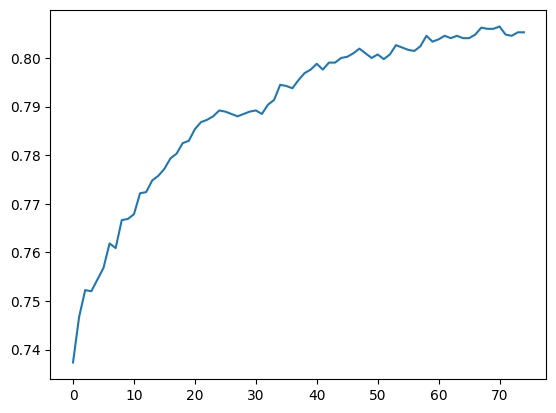

In [240]:
# for XGBoost, using nfolds = 10 and num_boost round = 75
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
end_time = time.time()
execution_time = end_time - start_time
scores = 1 - cv_results["test-merror-mean"]
scores_k10.append(scores[len(scores) - 1])
times_k10.append(execution_time)
print("=="*30)
print("XGBoostClassifier")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

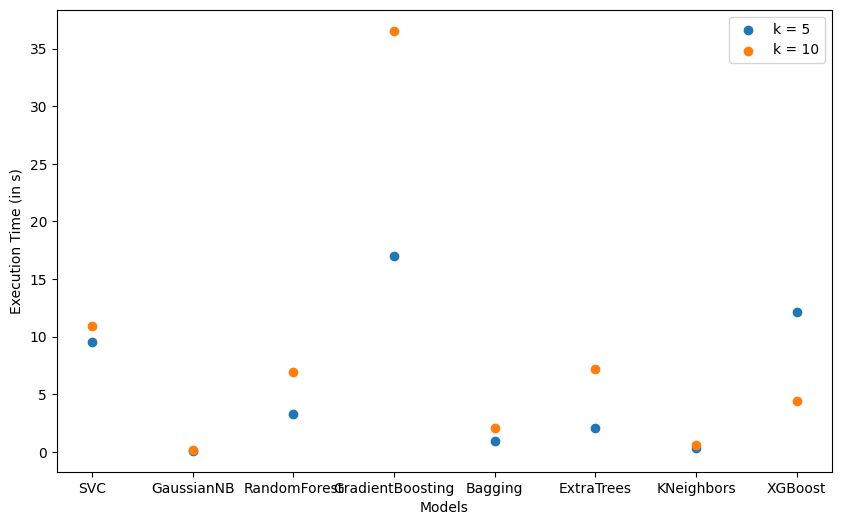

In [249]:
# plotting time comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), times_k5)
plt.scatter(models.keys(), times_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Execution Time (in s)")
plt.show()

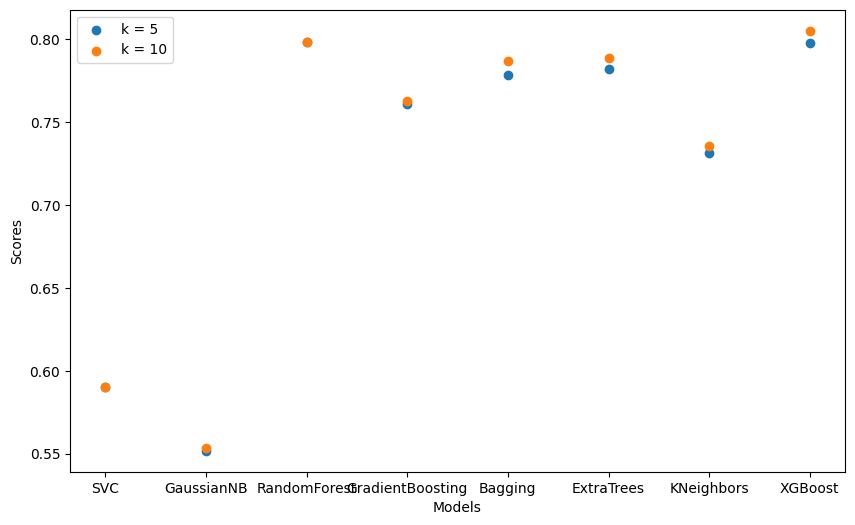

In [248]:
# plotting scores comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), scores_k5)
plt.scatter(models.keys(), scores_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.show()

For k = 10, based on cross_val_score and runtime on the entire training dataset, top 5 performing models remain the same as that obtained for k = 5, however the training time doubles and very little increase in scores is observed. A key observation is that XGBoost becomes the best model.

On incresing k-folds from 5 to 10, BaggingClassifier, KNeighborsClassifier and XGBoostClassifier do not show significant increase in execution times than other algorithms. Furthermore, BaggingClassifier, ExtraTreesClassifier and XGBoostClassifier show more significant improvements in accuracy score than other algorithms. So we use k-folds = 10 for these models.

We will use the 5 models and try to perform hyperparameter tuning to try to improve the model performance

In [14]:
# splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 24)

# splitting the training set further to get a cross_validation set
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.25, random_state = 24)

# printing...
print(f"Train: {X_train.shape}, {y_train.shape}")
#print(f"Train: {X_cv.shape}, {y_cv.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3332, 12), (3332,)
Test: (833, 12), (833,)


In [258]:
# Model 1: RandomForestClassifier
model_RFC = RandomForestClassifier(random_state=18, n_jobs = -1)
print(model_RFC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
# Create the GridSearchCV object
grid_search_RFC = GridSearchCV(model_RFC, param_grid, cv=5, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_RFC.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_RFC = pd.DataFrame(grid_search_RFC.cv_results_)
print(grid_search_RFC.best_params_)
# Print the best score
print(grid_search_RFC.best_score_)
# Get the best model
best_model = grid_search_RFC.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross validation set:")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
0.7911161536348943
Accuracy Score: 0.7839135654261705
Precision Score: 0.6595958039559187
Recall Score: 0.5195748597107115
F1 Score: 0.553053617169835
Model training time: 117.62744736671448 seconds


In [259]:
# Model 2: BaggingClassifier
model_BC = BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs = -1)
print(model_BC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_samples': [0.03, 0.1, 0.3, 1.0],
    'max_features': [0.5, 1.0],
    'estimator__max_depth': [2, 5, 10, 20]
}
# Create the GridSearchCV object
grid_search_BC = GridSearchCV(model_BC, param_grid, cv=10, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_BC.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_BC = pd.DataFrame(grid_search_BC.cv_results_)
print(grid_search_BC.best_params_)
# Print the best score
print(grid_search_BC.best_score_)
# Get the best model
best_model = grid_search_BC.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'estimator__max_depth': 20, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
0.7974132815450179
Accuracy Score: 0.7851140456182473
Precision Score: 0.6613772008454495
Recall Score: 0.5719397350077331
F1 Score: 0.6042330150908856
Model training time: 265.50673818588257 seconds


In [263]:
# Model 3: KNeighborsClassifier
model_KN = KNeighborsClassifier(n_jobs = -1)
print(model_BC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_neighbors' : [2, 3, 5, 8, 10, 13, 15, 18, 25],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
# Create the GridSearchCV object
grid_search_KN = GridSearchCV(model_KN, param_grid, cv=10, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_KN.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_KN = pd.DataFrame(grid_search_KN.cv_results_)
print(grid_search_KN.best_params_)
# Print the best score
print(grid_search_KN.best_score_)
# Get the best model
best_model = grid_search_KN.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
0.7734072395749043
Results for Cross-validation set
Accuracy Score: 0.7671068427370948
Precision Score: 0.7028600882240124
Recall Score: 0.5402775311770756
F1 Score: 0.5853287853341113
Model training time: 18.132063388824463 seconds


In [15]:
# Model 4: XGBoostClassifier
model_XG = xgb.XGBClassifier(random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
print(model_XG.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'max_depth' : [3, 5, 10, 20],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'min_child_weight' : [1, 5, 10, 50],
    'gamma' : [0, 0.3, 1, 3],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'reg_lambda' : [0.5, 1.0],
    'subsample' : [0.5, 1.0]
}
# Create the GridSearchCV object
grid_search_XG = GridSearchCV(model_XG, param_grid, cv = 10, scoring = 'accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_XG = pd.DataFrame(grid_search_XG.cv_results_)
print(grid_search_XG.best_params_)
# Print the best score
print(grid_search_XG.best_score_)
# Get the best model
best_model = grid_search_XG.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 75, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning:

The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.



AttributeError: 'super' object has no attribute '__sklearn_tags__'

Need to figure out how to perform hyperparameter tuning in XGBoost, also maybe preprocess the data more (like using log transformations and so on), finally, implement a neural network model.